# Linear rotating shallow water dynamics



This example solves the linear 1D rotating shallow water equations
for the ``u(x, t)``, ``v(x, t)`` and the surface surface elevation ``\eta(x, t)``,
for a fluid with constant rest-depth ``H``. That is, the total fluid's depth
is ``H + \eta(x, t)`` with ``|\eta| \ll H``.

The linearized equations for the evolution of ``u``, ``v``, ``\eta`` are:

$$
\begin{aligned}
\partial_t u - f v & = - g \partial_x \eta - \mathrm{D} u, \\
\partial_t v + f u & = - \mathrm{D} v, \\
\partial_t \eta + H \partial_x u & = - \mathrm{D} \eta.
\end{aligned}
$$

Above, ``g`` is the gravitational acceleration, ``f`` is the  Coriolis parameter, and
``\mathrm{D}`` indicates a hyperviscous linear operator of the form ``(-1)^{n_ν} ν \nabla^{2 n_ν}``,
with ``ν`` the viscosity coefficient and ``n_ν`` the order of the operator.

Rotation introduces the deformation length scale, ``L_d = \sqrt{g H} / f``. Disturbances with
length scales much smaller than ``L_d`` don't "feel" the rotation and propagate as inertia-gravity
waves. Disturbances with length scales comparable or larger than ``L_d`` should be approximately
in geostrophic balance, i.e., the Coriolis acceleration ``f \widehat{\bm{z}} \times \bm{u}``
should be in approximate balance with the pressure gradient ``-g \bm{\nabla} \eta``.

In [1]:
using FourierFlows, Plots, Printf, Random
using LinearAlgebra: mul!, ldiv!

## Coding up the equations
### A demonstration of FourierFlows.jl framework

What follows is a step-by-step tutorial demonstrating how you can create your own solver
for an equation of your liking.

The basic building blocks for a `FourierFlows.Problem` are:
- `Grid` struct containining the physical and wavenumber grid for the problem,
- `Params` struct containining all the parameters of the problem,
- `Vars` struct containining arrays with the variables used in the problem,
- `Equation` struct containining the coefficients of the linear operator ``L`` and the function that computes the nonlinear terms, usually named `calcN!()`.

The `Grid` structure is provided by FourierFlows.jl. We simply have to call one of either
`OneDGrid()`, `TwoDGrid()`, or `ThreeDGrid()` constructors, depending on the dimensionality
of the problem. All other structs mentioned above are problem-specific and need to be constructed
for every set of equations we want to solve.

First let's construct the `Params` struct that contains all parameters of the problem.

In [2]:
struct Params{T} <: AbstractParams
   ν :: T         # Hyperviscosity coefficient
  nν :: Int       # Order of the hyperviscous operator
   g :: T         # Gravitational acceleration
   H :: T         # Fluid depth
   f :: T         # Coriolis parameter
end
nothing #hide

Now the `Vars` struct that contains all variables used in this problem. For this
problem `Vars` includes the representations of the flow fields in physical space
`u`, `v` and `η` and their Fourier transforms `uh`, `vh`, and `ηh`.

In [3]:
struct Vars{Aphys, Atrans} <: AbstractVars
   u :: Aphys
   v :: Aphys
   η :: Aphys
  uh :: Atrans
  vh :: Atrans
  ηh :: Atrans
end
nothing #hide

A constructor populates empty arrays based on the dimension of the `grid`
and then creates `Vars` struct.

In [4]:
"""
    Vars(dev, grid)
Constructs Vars for 1D shallow water based on the dimensions of arrays of the `grid`.
"""
function Vars(::Dev, grid) where Dev
  T = eltype(grid)
  @devzeros Dev T grid.nx u v η
  @devzeros Dev Complex{T} grid.nkr uh vh ηh

  return Vars(u, v, η, uh, vh, ηh)
end
nothing #hide

In Fourier space, the 1D linear shallow water dynamics read:

$$
\begin{aligned}
\frac{\partial \hat{u}}{\partial t} & = \underbrace{ f \hat{v} - i k g \hat{\eta} }_{N_u} \; \underbrace{- \nu k^2 }_{L_u} \hat{u} , \\
\frac{\partial \hat{v}}{\partial t} & = \underbrace{ - f \hat{u} }_{N_v} \; \underbrace{- \nu k^2 }_{L_v} \hat{v} , \\
\frac{\partial \hat{\eta}}{\partial t} & = \underbrace{ - i k H \hat{u} }_{N_{\eta}} \; \underbrace{- \nu k^2 }_{L_{\eta}} \hat{\eta} .
\end{aligned}
$$
Although, e.g., terms involving the Coriolis accelaration are, in principle, linear we include
them in the nonlinear term ``N`` because they render the linear operator ``L`` non-diagonal.

With these in mind, we construct function `calcN!` that computes the nonlinear terms.

In [5]:
"""
    calcN!(N, sol, t, clock, vars, params, grid)
Compute the nonlinear terms for 1D linear shallow water dynamics.
"""
function calcN!(N, sol, t, clock, vars, params, grid)
  @. vars.uh = sol[:, 1]
  @. vars.vh = sol[:, 2]
  @. vars.ηh = sol[:, 3]

  @. N[:, 1] =   params.f * vars.vh - im * grid.kr * params.g * vars.ηh    #  + f v - g ∂η/∂x
  @. N[:, 2] = - params.f * vars.uh                                        #  - f u
  @. N[:, 3] = - im * grid.kr * params.H * vars.uh                         #  - H ∂u/∂x

  dealias!(N, grid)

  return nothing
end
nothing #hide

Next we construct the `Equation` struct:

In [6]:
"""
    Equation(dev, params, grid)
Construct the equation: the linear part, in this case the hyperviscous dissipation,
and the nonlinear part, which is computed by `calcN!` function.
"""
function Equation(dev, params, grid)
  T = eltype(grid)
  L = zeros(dev, T, (grid.nkr, 3))
  D = @. - params.ν * grid.kr^(2*params.nν)

  L[:, 1] .= D # for u equation
  L[:, 2] .= D # for v equation
  L[:, 3] .= D # for η equation

  return FourierFlows.Equation(L, calcN!, grid)
end
nothing #hide

We now have all necessary building blocks to construct a `FourierFlows.Problem`.
It would be useful, however, to define some more "helper functions". For example,
a function that updates all variables given the solution `sol` which comprises ``\hat{u}``,
``\hat{v}`` and ``\hat{\eta}``:

In [7]:
"""
    updatevars!(prob)
Update the variables in `prob.vars` using the solution in `prob.sol`.
"""
function updatevars!(prob)
  vars, grid, sol = prob.vars, prob.grid, prob.sol

  @. vars.uh = sol[:, 1]
  @. vars.vh = sol[:, 2]
  @. vars.ηh = sol[:, 3]

  ldiv!(vars.u, grid.rfftplan, deepcopy(sol[:, 1])) # use deepcopy() because irfft destroys its input
  ldiv!(vars.v, grid.rfftplan, deepcopy(sol[:, 2])) # use deepcopy() because irfft destroys its input
  ldiv!(vars.η, grid.rfftplan, deepcopy(sol[:, 3])) # use deepcopy() because irfft destroys its input

  return nothing
end
nothing #hide

Another useful function is one that prescribes an initial condition to the state variable `sol`.

In [8]:
"""
    set_uvη!(prob, u0, v0, η0)
Sets the state variable `prob.sol` as the Fourier transforms of `u0`, `v0`, and `η0`
and update all variables in `prob.vars`.
"""
function set_uvη!(prob, u0, v0, η0)
  vars, grid, sol = prob.vars, prob.grid, prob.sol

  A = typeof(vars.u) # determine the type of vars.u

  mul!(vars.uh, grid.rfftplan, A(u0)) # A(u0) converts u0 to the same type as vars expects (useful if u0 is a CPU array while working on the GPU)
  mul!(vars.vh, grid.rfftplan, A(v0)) # A(v0) converts u0 to the same type as vars expects (useful if v0 is a CPU array while working on the GPU)
  mul!(vars.ηh, grid.rfftplan, A(η0)) # A(η0) converts u0 to the same type as vars expects (useful if η0 is a CPU array while working on the GPU)

  @. sol[:, 1] = vars.uh
  @. sol[:, 2] = vars.vh
  @. sol[:, 3] = vars.ηh

  updatevars!(prob)

  return nothing
end
nothing #hide

## Let's prescibe parameter values and solve the PDE

We are now ready to write up a program that sets up parameter values, constructs
the problem `prob`, # time steps the solutions `prob.sol` and plots it.

## Choosing a device: CPU or GPU

In [9]:
dev = CPU()    # Device (CPU/GPU)
nothing # hide

## Numerical parameters and time-stepping parameters

In [10]:
     nx = 512            # grid resolution
stepper = "FilteredRK4"  # timestepper
     dt = 20.0           # timestep (s)
 nsteps = 320            # total number of time-steps
nothing # hide

## Physical parameters

In [11]:
Lx = 500e3      # Domain length (m)
g  = 9.8        # Gravitational acceleration (m s⁻²)
H  = 200.0      # Fluid depth (m)
f  = 1e-2       # Coriolis parameter (s⁻¹)
ν  = 100.0      # Viscosity (m² s⁻¹)
nν = 1          # Viscosity order (nν = 1 means Laplacian ∇²)
nothing # hide

## Construct the `struct`s and you are ready to go!
Create a `grid` and also `params`, `vars`, and the `equation` structs. Then
give them all as input to the `FourierFlows.Problem()` constructor to get a
problem struct, `prob`, that contains all of the above.

In [12]:
    grid = OneDGrid(dev, nx, Lx)
  params = Params(ν, nν, g, H, f)
    vars = Vars(dev, grid)
equation = Equation(dev, params, grid)

    prob = FourierFlows.Problem(equation, stepper, dt, grid, vars, params, dev)
nothing #hide

## Setting initial conditions

For initial condition we take the fluid at rest (``u = v = 0``). The free surface elevation
is perturbed from its rest position (``\eta=0``); the disturbance we impose a Gaussian
bump with half-width greater than the deformation radius and on top of that we
superimpose some random noise with scales smaller than the deformation radius.
We mask the small-scale perturbations so that it only applies in the central part
of the domain by applying

The system develops geostrophically-balanced jets around the Gaussian bump,
while the smaller-scale noise propagates away as inertia-gravity waves.

First let's construct the Gaussian bump.

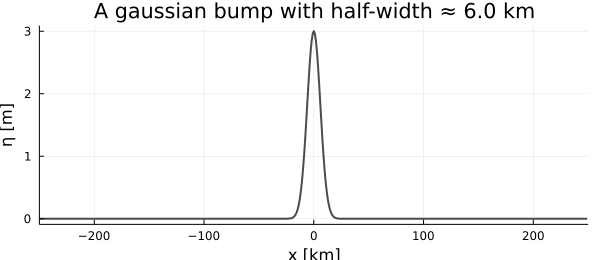

In [13]:
gaussian_width = 6e3
gaussian_amplitude = 3.0
gaussian_bump = @. gaussian_amplitude * exp( - grid.x^2 / (2*gaussian_width^2) )

plot(grid.x/1e3, gaussian_bump,    # divide with 1e3 to convert m -> km
     color = :black,
    legend = false,
 linewidth = 2,
     alpha = 0.7,
     xlims = (-Lx/2e3, Lx/2e3),
    xlabel = "x [km]",
    ylabel = "η [m]",
     title = "A gaussian bump with half-width ≈ "*string(gaussian_width/1e3)*" km",
      size = (600, 260))

Next the noisy perturbation. The `mask` is simply a product of hyperbolic tangent functions.

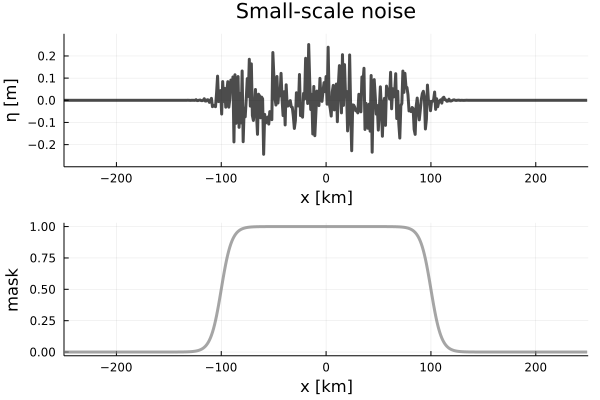

In [14]:
mask = @. 1/4 * (1 + tanh( -(grid.x - 100e3) / 10e3)) * (1 + tanh( (grid.x + 100e3) / 10e3))

noise_amplitude = 0.1 # the amplitude of the noise for η(x,t=0) (m)
η_noise = noise_amplitude * Random.randn(size(grid.x))
@. η_noise *= mask    # mask the noise

plot_noise = plot(grid.x/1e3, η_noise,      # divide with 1e3 to convert m -> km
                 color = :black,
                legend = :false,
             linewidth = [3 2],
                 alpha = 0.7,
                 xlims = (-Lx/2e3, Lx/2e3), # divide with 1e3 to convert m -> km
                 ylims = (-0.3, 0.3),
                xlabel = "x [km]",
                ylabel = "η [m]")

plot_mask = plot(grid.x/1e3, mask,          # divide with 1e3 to convert m -> km
                 color = :gray,
                legend = :false,
             linewidth = [3 2],
                 alpha = 0.7,
                 xlims = (-Lx/2e3, Lx/2e3), # divide with 1e3 to convert m -> km
                xlabel = "x [km]",
                ylabel = "mask")

title = plot(title = "Small-scale noise",
              grid = false,
          showaxis = false,
            xticks = [],
            yticks = [],
     bottom_margin = -20Plots.px)

plot(title, plot_noise, plot_mask,
           layout = @layout([A{0.01h}; [B; C]]),
             size = (600, 400))

Sum the Gaussian bump and the noise and then call `set_uvη!()` to set the initial condition to the problem `prob`.

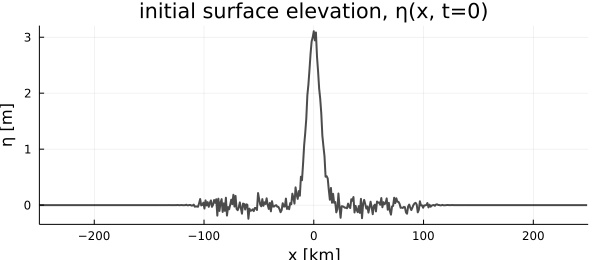

In [15]:
η0 = @. gaussian_bump + η_noise
u0 = zeros(grid.nx)
v0 = zeros(grid.nx)

set_uvη!(prob, u0, v0, η0)

plot(grid.x/1e3, η0,    # divide with 1e3 to convert m -> km
     color = :black,
    legend = false,
 linewidth = 2,
     alpha = 0.7,
     xlims = (-Lx/2e3, Lx/2e3),
    xlabel = "x [km]",
    ylabel = "η [m]",
     title = "initial surface elevation, η(x, t=0)",
      size = (600, 260))

## Visualizing the simulation

We define a function that plots the surface elevation ``\eta`` and the
depth-integrated velocities ``u`` and ``v``.

In [16]:
function plot_output(prob)
  plot_η = plot(grid.x/1e3, vars.η,         # divide with 1e3 to convert m -> km
                 color = :blue,
                legend = false,
             linewidth = 2,
                 alpha = 0.7,
                 xlims = (-Lx/2e3, Lx/2e3), # divide with 1e3 to convert m -> km
                xlabel = "x [km]",
                ylabel = "η [m]")

  plot_u = plot(grid.x/1e3, vars.u,         # divide with 1e3 to convert m -> km
                 color = :red,
                legend = false,
             linewidth = 2,
                 alpha = 0.7,
                 xlims = (-Lx/2e3, Lx/2e3), # divide with 1e3 to convert m -> km
                 ylims = (-0.3, 0.3),
                xlabel = "x [km]",
                ylabel = "u [m s⁻¹]")

  plot_v = plot(grid.x/1e3, vars.v,         # divide with 1e3 to convert m -> km
                 color = :green,
                legend = false,
             linewidth = 2,
                 alpha = 0.7,
                 xlims = (-Lx/2e3, Lx/2e3), # divide with 1e3 to convert m -> km
                 ylims = (-0.3, 0.3),
                xlabel = "x [km]",
                ylabel = "v [m s⁻¹]")

  Ld = @sprintf "%.2f" sqrt(g*H)/f /1e3     # divide with 1e3 to convert m -> km
  plottitle = "Deformation radius √(gh) / f = "*string(Ld)*" km"

  title = plot(title = plottitle,
                grid = false,
            showaxis = false,
              xticks = [],
              yticks = [],
       bottom_margin = -30Plots.px)

  return plot(title, plot_η, plot_u, plot_v,
           layout = @layout([A{0.01h}; [B; C; D]]),
             size = (600, 800))
end
nothing # hide

## Time-stepping the `Problem` forward

We time-step the `Problem` forward in time. We update variables by calling
`updatevars!()` and we also update the plot. We enclose the `for` loop in
an `@animate` macro to produce an animation of the solution.

In [17]:
p = plot_output(prob)

anim = @animate for j = 0:nsteps
  updatevars!(prob)

  p[2][1][:y] = vars.η    # updates the plot for η
  p[2][:title] = "t = " * @sprintf("%.1f", prob.clock.t/60) * " min" # updates time in the title
  p[3][1][:y] = vars.u    # updates the plot for u
  p[4][1][:y] = vars.v    # updates the plot for v

  stepforward!(prob)
end

mp4(anim, "onedshallowwater.mp4", fps=18)

┌ Info: Saved animation to 
└   fn = "/home/runner/work/FourierFlows.jl/FourierFlows.jl/docs/src/literated/onedshallowwater.mp4"


Plots.AnimatedGif("/home/runner/work/FourierFlows.jl/FourierFlows.jl/docs/src/literated/onedshallowwater.mp4")

## Geostrophic balance

It is instructive to compare the solution for ``v`` with its geostrophically balanced approximation, ``f \widehat{\bm{z}} \times \bm{u}_{\rm geostrophic} = - g \bm{\nabla} \eta``, i.e.,

$$
\begin{aligned}
v_{\rm geostrophic} & =   \frac{g}{f} \frac{\partial \eta}{\partial x} \ , \\
u_{\rm geostrophic} & = - \frac{g}{f} \frac{\partial \eta}{\partial y} = 0 \ .
\end{aligned}
$$
The geostrophic solution should capture well the the behavior of the flow in
the center of the domain, after small-scale disturbances propagate away.

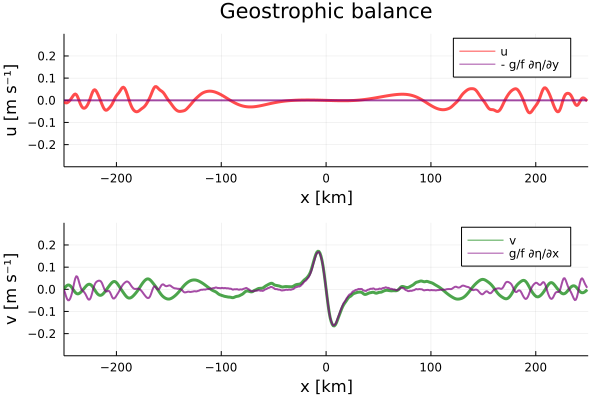

In [18]:
u_geostrophic = zeros(grid.nx)  # -g/f ∂η/∂y = 0
v_geostrophic = params.g / params.f * irfft(im * grid.kr .* vars.ηh, grid.nx)  #g/f ∂η/∂x

plot_u = plot(grid.x/1e3, [vars.u u_geostrophic], # divide with 1e3 to convert m -> km
                 color = [:red :purple],
                labels = ["u" "- g/f ∂η/∂y"],
             linewidth = [3 2],
                 alpha = 0.7,
                 xlims = (-Lx/2e3, Lx/2e3),       # divide with 1e3 to convert m -> km
                 ylims = (-0.3, 0.3),
                xlabel = "x [km]",
                ylabel = "u [m s⁻¹]")

plot_v = plot(grid.x/1e3, [vars.v v_geostrophic], # divide with 1e3 to convert m -> km
                 color = [:green :purple],
                labels = ["v" "g/f ∂η/∂x"],
             linewidth = [3 2],
                 alpha = 0.7,
                 xlims = (-Lx/2e3, Lx/2e3),       # divide with 1e3 to convert m -> km
                 ylims = (-0.3, 0.3),
                xlabel = "x [km]",
                ylabel = "v [m s⁻¹]")

title = plot(title = "Geostrophic balance",
              grid = false,
          showaxis = false,
            xticks = [],
            yticks = [],
     bottom_margin = -20Plots.px)

plot(title, plot_u, plot_v,
           layout = @layout([A{0.01h}; [B; C]]),
             size = (600, 400))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*